In [1]:
import torch
from glob import glob
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data.dataset import Dataset
from torchvision import models, transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from torch_lr_finder import LRFinder

/home/oren/anaconda3/envs/py3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## General helper functions

In [2]:
def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False
        
def freeze(layer):
    for param in layer.parameters():
        param.requires_grad = False
        
def unfreeze_all(model_params):
    for param in model_params:
        param.requires_grad = True
        
def unfreeze(layer):
    for param in layer.parameters():
        param.requires_grad = True
        
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)

def load_image(filename) :
    img = Image.open(filename)
    img = img.convert('RGB')
    return img

## Load the Resnet Model

In [3]:
vgg_model = models.vgg16_bn(pretrained=True)
vgg_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Get the data and do preprocessing

In [4]:
filenames = glob('./datasets/images/*.jpg')

In [5]:
classes = set()

data = []
labels = []

# Load the images and get the classnames from the image path
for image in filenames:
    class_name = image.rsplit("/", 1)[1].rsplit('_', 1)[0]
    classes.add(class_name)
    img = load_image(image)

    data.append(img)
    labels.append(class_name)

# convert classnames to indices
class2idx = {cl: idx for idx, cl in enumerate(classes)}        
labels = torch.Tensor(list(map(lambda x: class2idx[x], labels))).long()

data = list(zip(data, labels))

In [6]:
class PetDataset(Dataset):
    "Dataset to serve individual images to our model"
    
    def __init__(self, data, transforms=None):
        self.data = data
        self.len = len(data)
        self.transforms = transforms
    
    def __getitem__(self, index):
        img, label = self.data[index]
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, label
    
    def __len__(self):
        return self.len


# Since the data is not split into train and validation datasets we have to 
# make sure that when splitting between train and val that all classes are represented in both
class Databasket:
    "Helper class to ensure equal distribution of classes in both train and validation datasets"
    
    def __init__(self, data, num_cl, val_split=0.2, train_transforms=None, val_transforms=None):
        class_values = [[] for x in range(num_cl)]
        
        # create arrays for each class type
        for d in data:
            class_values[d[1].item()].append(d)
            
        self.train_data = []
        self.val_data = []
        
        # put (1-val_split) of the images of each class into the train dataset
        # and val_split of the images into the validation dataset
        for class_dp in class_values:
            split_idx = int(len(class_dp)*(1-val_split))
            self.train_data += class_dp[:split_idx]
            self.val_data += class_dp[split_idx:]
            
        self.train_ds = PetDataset(self.train_data, transforms=train_transforms)
        self.val_ds = PetDataset(self.val_data, transforms=val_transforms)

In [7]:
from sklearn.model_selection import train_test_split

# Apply transformations to the train dataset
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# apply the same transformations to the validation set, with the exception of the
# randomized transformation. We want the validation set to be consistent
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

databasket = Databasket(data, len(classes), val_split=0.2, train_transforms=train_transforms,
                        val_transforms=val_transforms)

In [8]:
def decimate(tensor, m):
    """
    Decimate a tensor by a factor 'm', i.e. downsample by keeping every 'm'th value.
    This is used when we convert FC layers to equivalent Convolutional layers, BUT of a smaller size.
    :param tensor: tensor to be decimated
    :param m: list of decimation factors for each dimension of the tensor; None if not to be decimated along a dimension
    :return: decimated tensor
    """
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d,
                                         index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())

    return tensor

def make_fcn_classifier(in_features, num_classes, convert_from_dense=False):
    model = models.vgg16_bn(pretrained=True)
    features = model.features
    fcLayers = nn.Sequential(
        # stop at last layer group
        *list(model.classifier.children())[:-1]
    )
    fc = fcLayers[0].state_dict()
    in_ch = in_features
    out_ch = fc["weight"].size(0)
    assert out_ch == 4096
    conv1 = nn.Conv2d(in_ch, 1024, kernel_size=3)
    if convert_from_dense:
        conv_fc6_weight = fc["weight"].view(out_ch, in_ch, 7, 7)
        conv_fc6_bias = fc["bias"]
        conv1_weights = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        conv1_bias = decimate(conv_fc6_bias, m=[4])  # (1024)
        conv1.load_state_dict({"weight": conv1_weights,
                               "bias": conv1_bias})
        
    return nn.Sequential(
        conv1,
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=5),
        nn.Flatten()
    )
    
def requires_grad(layer):
    "Determines whether 'layer' requires gradients"
    ps = list(layer.parameters())
    if not ps: return None
    return ps[0].requires_grad

def cnn_model(model, nc, convert_from_dense=False, init=nn.init.kaiming_normal_):
    bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)
    "Creates a model using a pretrained 'model' and appends a new head to it with 'nc' outputs"
    
    # remove dense and freeze everything
    body = nn.Sequential(*list(model.children())[:-2])
    head = make_fcn_classifier(512, nc, convert_from_dense=convert_from_dense)
    
    model = nn.Sequential(body, head)
    
    # freeze the resnet34 base of the model
    freeze_all(model[0].parameters())
    
    # initialize the weights of the head
    for i, child in enumerate(model[1].children()):
        if i == 0 and convert_from_dense:
            freeze(child)
            continue
        if isinstance(child, nn.Module) and (not isinstance(child, bn_types)) and requires_grad(child): 
            init(child.weight)
    
    return model

num_classes = len(classes)
model = cnn_model(vgg_model, num_classes, convert_from_dense=True)

In [9]:
model.eval()

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [10]:
train_indices = list(range(len(databasket.train_ds)))
test_indices = list(range(len(databasket.val_ds)))

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

bs = 32

# Basic dataloader to retrieve mini-batches from the datasets
train_loader = DataLoader(databasket.train_ds, batch_size=bs,
                          sampler=train_sampler, shuffle=False, num_workers=0)
test_loader = DataLoader(databasket.val_ds, batch_size=bs,
                         sampler=test_sampler, shuffle=False, num_workers=0)

In [11]:
criterion = torch.nn.CrossEntropyLoss()

# We don't actually use the learning rate here. It's set to 1e-7 so that the LR Finder
# starts at 1e-7
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-5)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


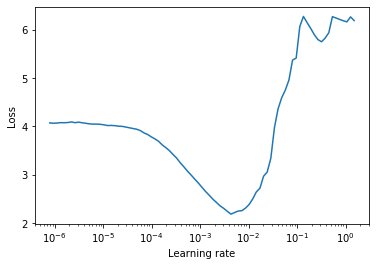

In [12]:
# used to find the ideal LR for our model training
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=3, num_iter=100)
lr_finder.plot()

In [13]:
# A one cycle LR scheduler (https://arxiv.org/abs/1708.07120)
# max_lr is derived from the lr_finder plot
# epochs must match the amount of epochs you will run
n_epochs = 15
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=8e-3, pct_start=0.3,
                                          steps_per_epoch=len(train_loader), epochs=n_epochs)

In [14]:
device = 'cuda:0'
model.to(device)

def train(epochs, scheduler, optimizer, model):
    for epoch in range(epochs):
        running_loss = 0
        n_correct = 0
        
        # use dropouts and batchnorms
        model.train()
        for batch in train_loader:
            inputs, labels = batch
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            #zero the parameter gradients
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            scheduler.step()
            
            _, predicted = torch.max(outputs, 1)
            n_correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
        
        train_acc = 100. * n_correct / len(databasket.train_ds)
        train_loss = running_loss / len(train_loader)
        
        n_val_correct = 0
        val_loss = 0
        
        # disable batchnorm and dropouts
        model.eval()
        # don't calculate gradient
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                val_loss = criterion(outputs, labels).item()

                n_val_correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
       
        val_acc = 100. * n_val_correct / len(databasket.val_ds)   
        print('Epoch {}: Train Accuracy: {}%, Validation Accuracy: {}%, Train Loss: {}, Validation Loss: {}' 
              .format(epoch, *np.around([train_acc, val_acc, train_loss, val_loss], 2)))
        
train(n_epochs, scheduler, optimizer, model)

Epoch 0: Train Accuracy: 5.41%, Validation Accuracy: 6.15%, Train Loss: 33.78, Validation Loss: 6.75
Epoch 1: Train Accuracy: 8.7%, Validation Accuracy: 13.46%, Train Loss: 12.63, Validation Loss: 4.91
Epoch 2: Train Accuracy: 19.91%, Validation Accuracy: 31.51%, Train Loss: 3.54, Validation Loss: 5.15
Epoch 3: Train Accuracy: 36.54%, Validation Accuracy: 49.22%, Train Loss: 2.18, Validation Loss: 0.97
Epoch 4: Train Accuracy: 52.24%, Validation Accuracy: 63.56%, Train Loss: 1.55, Validation Loss: 1.51
Epoch 5: Train Accuracy: 61.97%, Validation Accuracy: 69.44%, Train Loss: 1.18, Validation Loss: 0.71
Epoch 6: Train Accuracy: 68.14%, Validation Accuracy: 73.77%, Train Loss: 0.97, Validation Loss: 1.23
Epoch 7: Train Accuracy: 72.81%, Validation Accuracy: 77.48%, Train Loss: 0.83, Validation Loss: 0.28
Epoch 8: Train Accuracy: 75.71%, Validation Accuracy: 79.72%, Train Loss: 0.74, Validation Loss: 0.29
Epoch 9: Train Accuracy: 79.02%, Validation Accuracy: 81.74%, Train Loss: 0.64, Vali

In [17]:
unfreeze_all(model.parameters())

In [18]:
# discriminative learning rate for fine tuning
optimizer = optim.Adam([
        {"params": model[0].parameters(), "lr": 1e-7},
        {"params": model[1].parameters(), "lr": 1e-7}
    ],  weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=(1e-6,1e-3), pct_start=0.8, steps_per_epoch=len(train_loader), epochs=5)
train(5, scheduler, optimizer, model)

Epoch 0: Train Accuracy: 84.37%, Validation Accuracy: 81.68%, Train Loss: 0.47, Validation Loss: 0.23
Epoch 1: Train Accuracy: 82.35%, Validation Accuracy: 81.68%, Train Loss: 0.55, Validation Loss: 0.27
Epoch 2: Train Accuracy: 85.03%, Validation Accuracy: 84.31%, Train Loss: 0.47, Validation Loss: 0.5
Epoch 3: Train Accuracy: 88.14%, Validation Accuracy: 84.99%, Train Loss: 0.35, Validation Loss: 0.37
Epoch 4: Train Accuracy: 91.44%, Validation Accuracy: 86.61%, Train Loss: 0.26, Validation Loss: 0.99
